# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Predict the price of a used car given ....

We want to determine which features of this used cars dataset are the best predictors of the price.

Using a variety of modeling techniques, we will look for features in this dataset that are useful in predicting used car price.
The goal is to identify a combination of features and create a regression model that can be used to predict the price of used cars.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In order to begin this process, it is important to explore the data and understand the types of features provided, what types of values they have.

Therefore some initial visualizations and statistics will be important to gain familiarity with the data and attempt to identify a useful subset of columns to use in building models.

In addition some initial understanding of data quality, outliers, potential erroneous values, etc. will be helpful as well.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

In [10]:
cars = pd.read_csv('data/vehicles.csv')

In [11]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [12]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [13]:
print("Percent of Null Values by Column")
print(cars.isnull().mean()*100)

Percent of Null Values by Column
id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


In [14]:
# check for duplicated rows
cars.duplicated().sum()

0

In [15]:
# look at basic statistics on the numeric columns
cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [16]:
# There seems to be some huge price outliers that are way too high and are likely errors
# These high price values are also impacting the ability to generate meaningful visualizations of the rest of the data.
# I am going to limit the data to just rows where the price is below 100,000.
# I am also going to remove rows where the price is $0

cars = cars[(cars["price"]> 0) & (cars["price"]<=100000)]

# There also seem to be some odometer outliers with values of 10,000,000 miles!
# This seems like an error so I will remove rows with values over 500,000 miles
cars = cars[cars["odometer"]<= 500000]

#in addition, I will remove meaningless columns like id and VIN that will not help predict price
cars = cars.drop(['id', 'VIN'], axis = 1)
cars.shape


(389830, 16)

In [17]:
# look at basic statistics on the object columns
cars.describe(include = 'object')

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
count,389830,374406,385356,240160,231469,387511,382367,388318,271040,109998,305216,274528,389830
unique,404,42,27754,6,8,5,6,3,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,ca
freq,3384,64289,7017,118561,88118,327326,369131,303811,119632,57945,79644,72220,44313


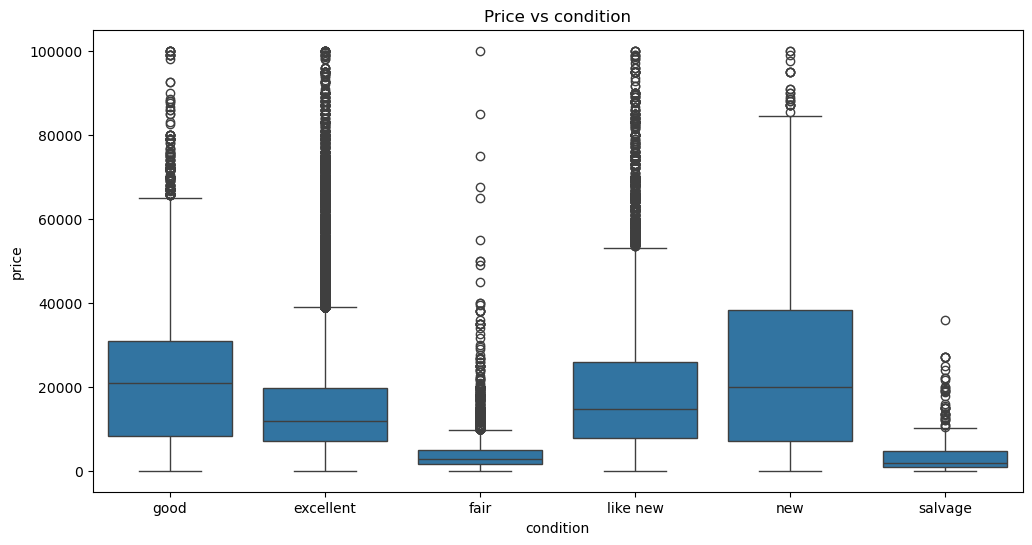

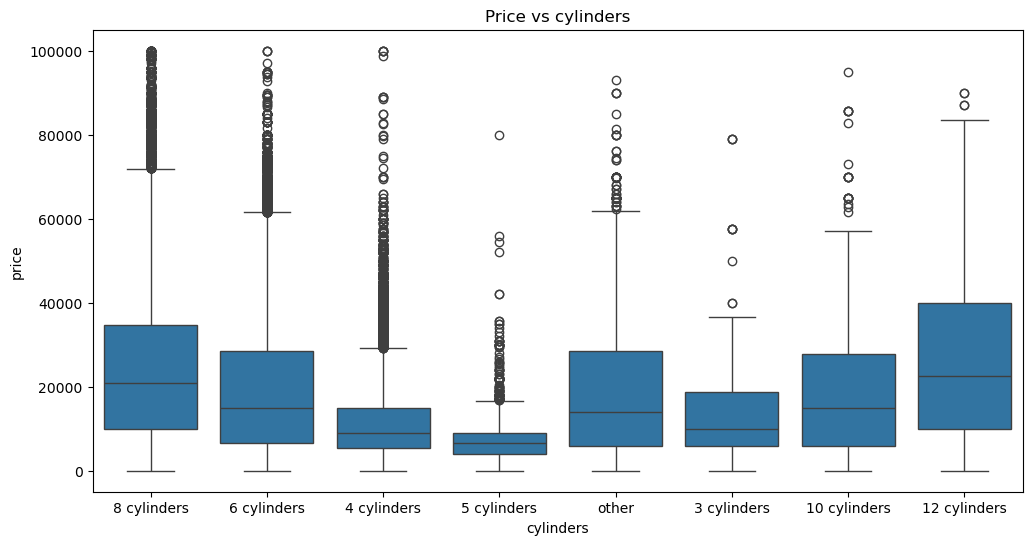

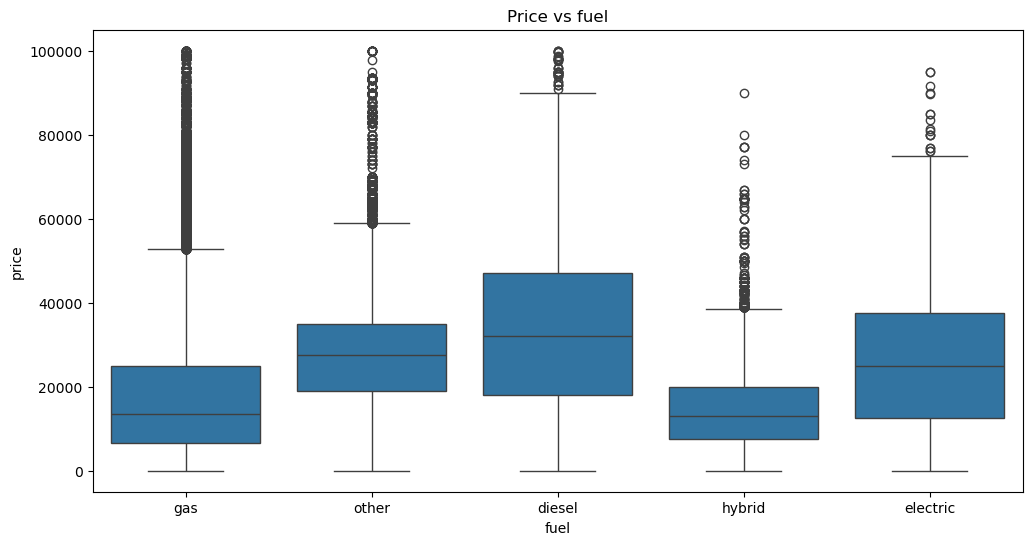

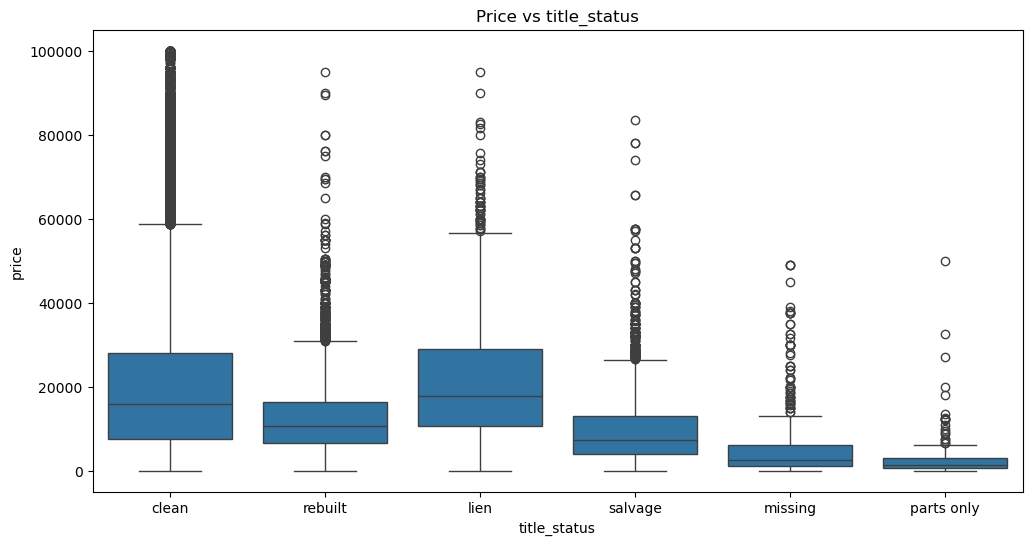

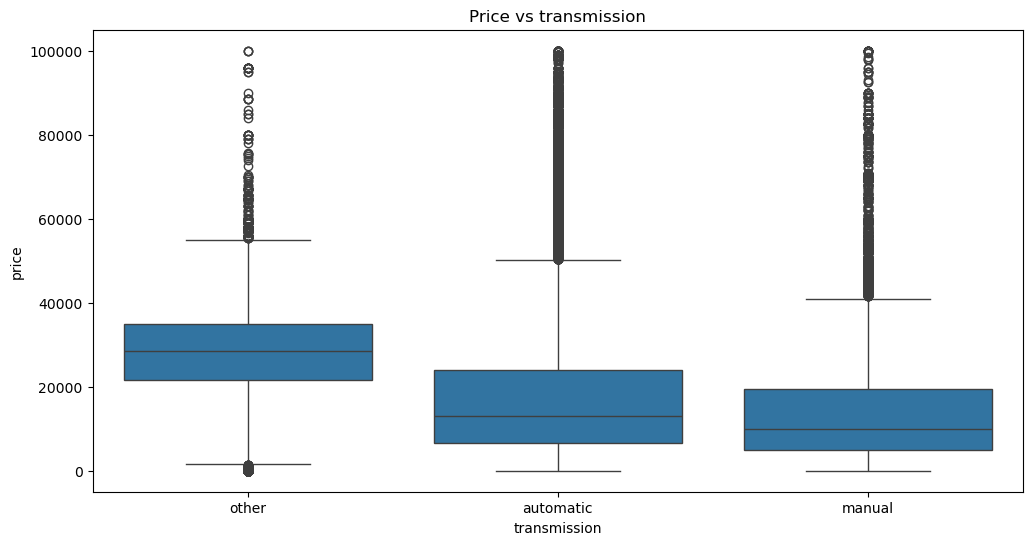

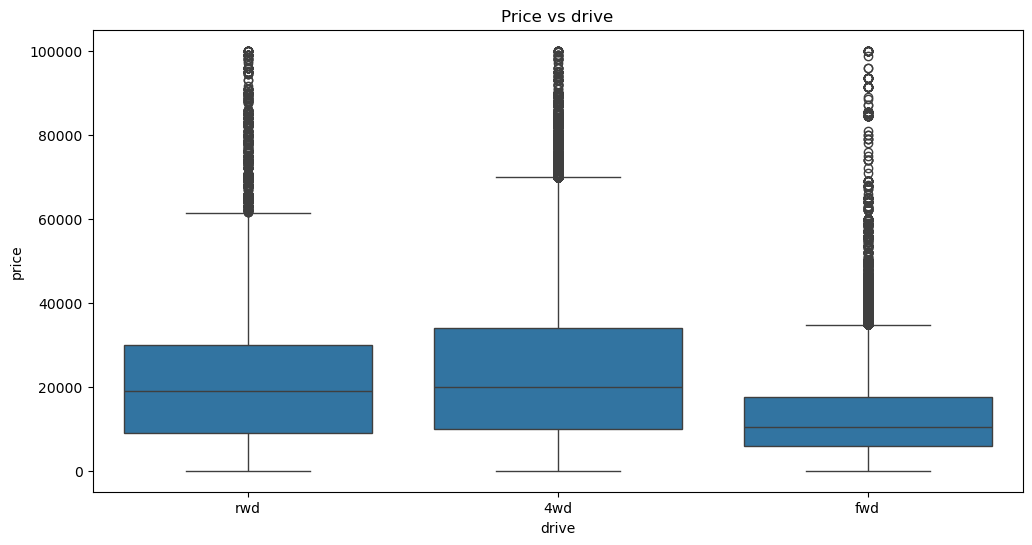

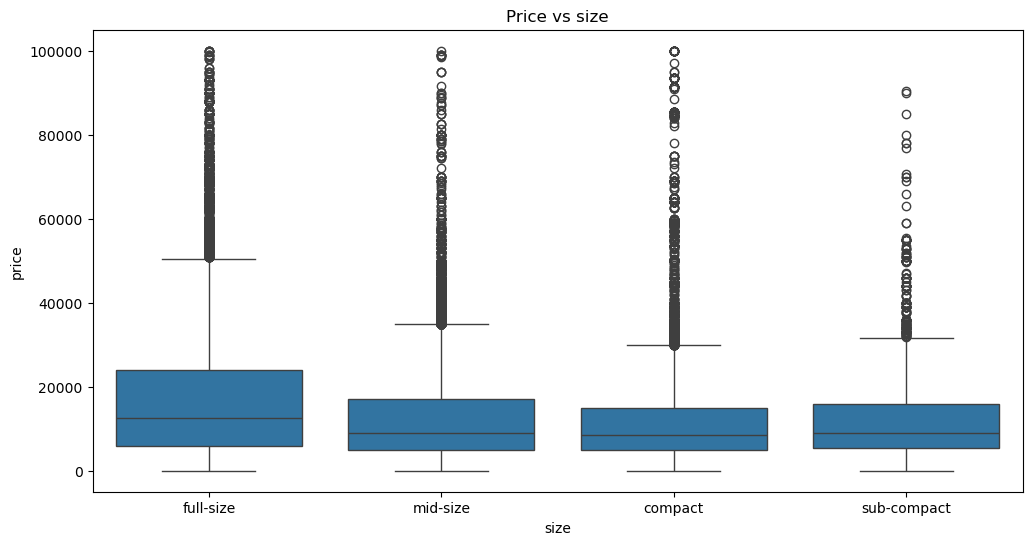

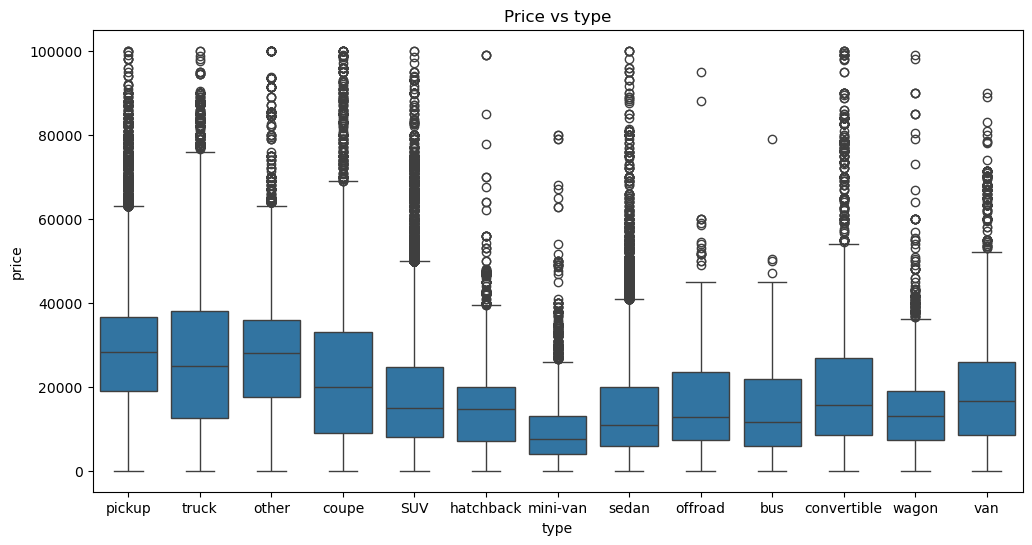

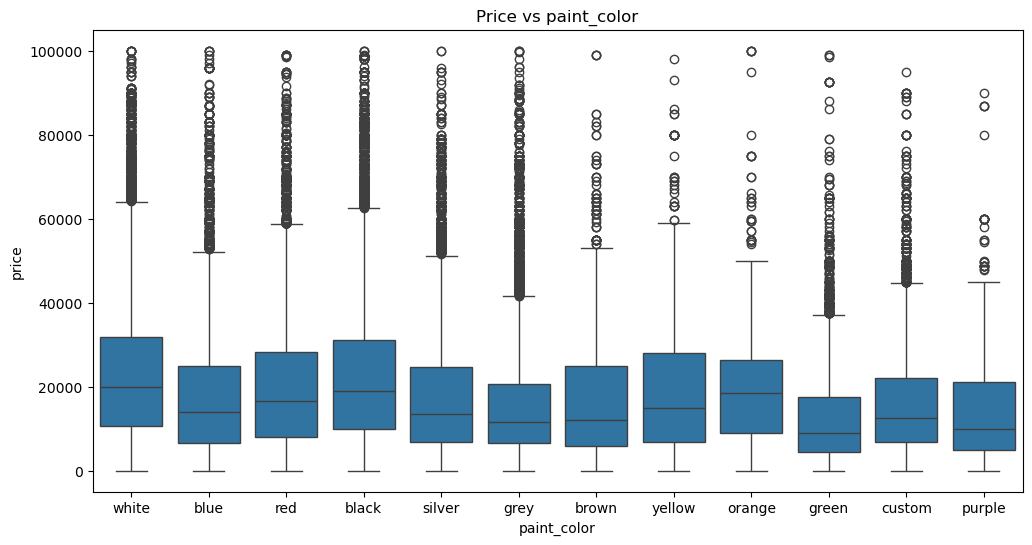

In [18]:
# some of these columns, like region, model, state and manufacturer have a lot of values
# Let's start by focusing on the columns with fewer values

# visualizing the categorical columns 
# create a box plot for each of the categorical columns with a limited number of values
columns = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type' ,'paint_color']

for col in columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=cars, x=cars[col], y=cars['price'])
    plt.title("Price vs "+ col)
    plt.show()

Based on these preliminary graphs, it seems like condition and cylinders are potentially related to price.
So I want to be sure to include those in my analysis. 
Other fields, like color, seem to potentially be less impactful.

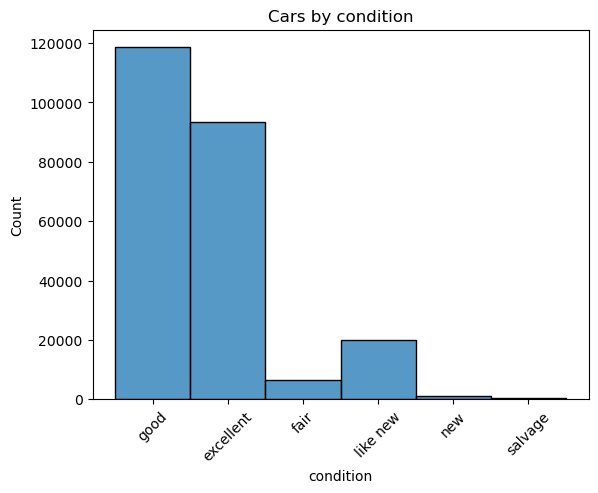

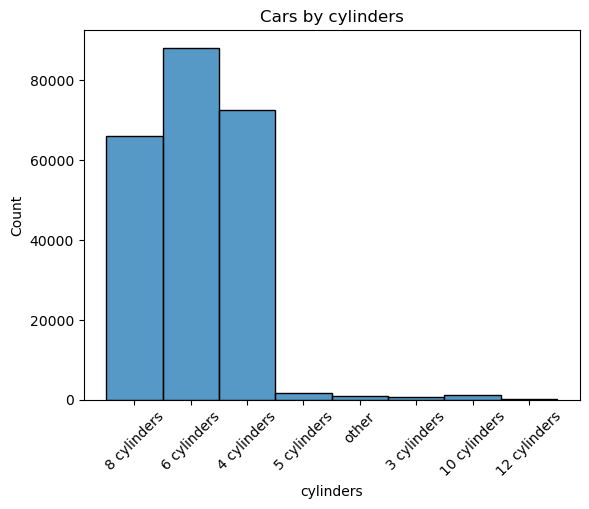

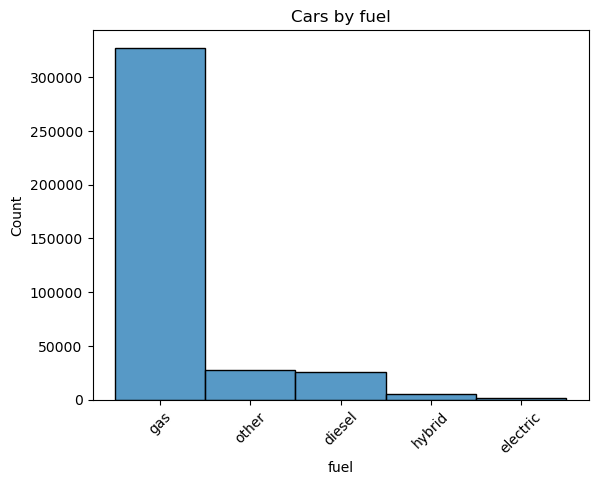

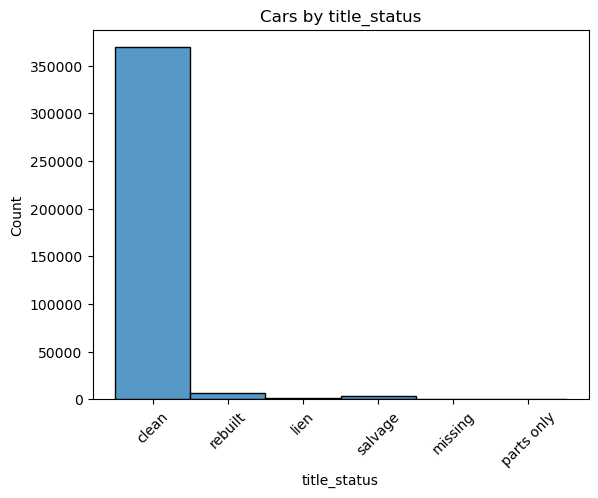

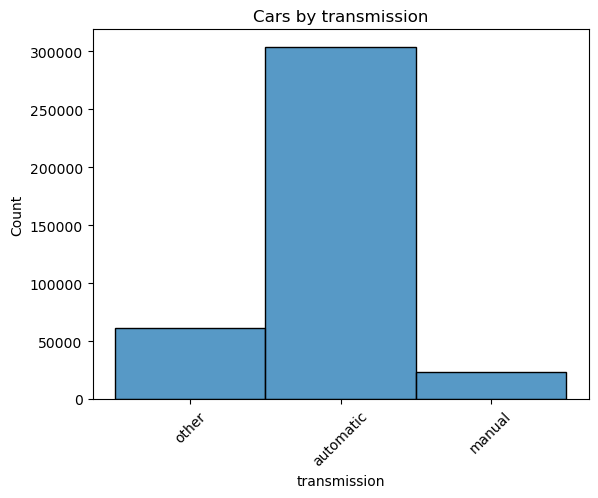

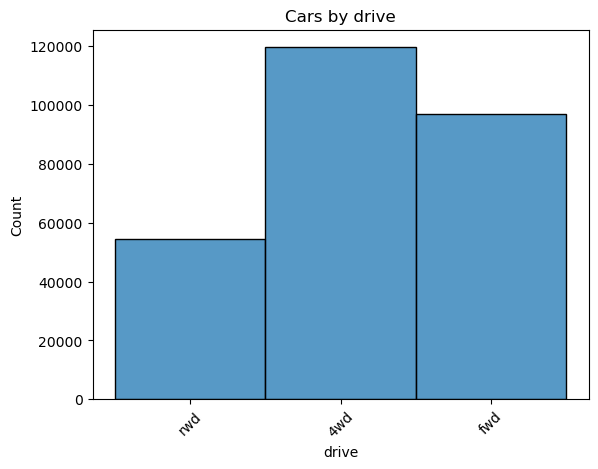

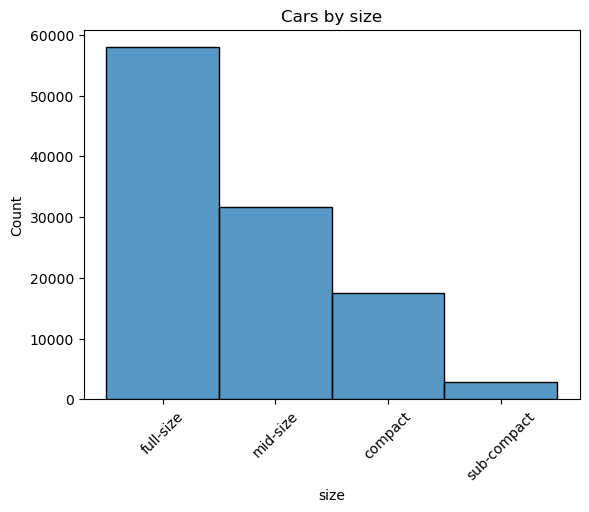

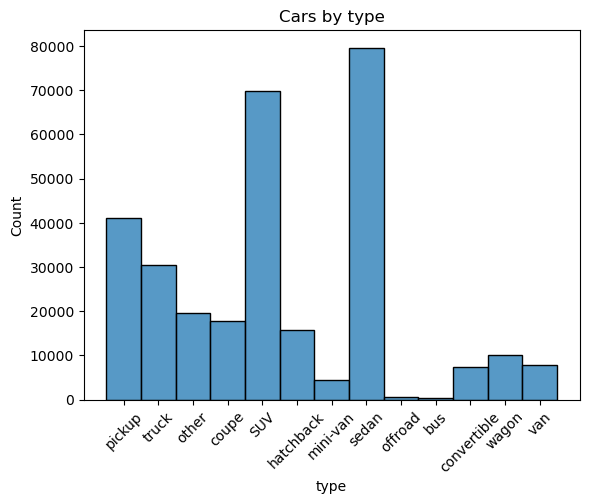

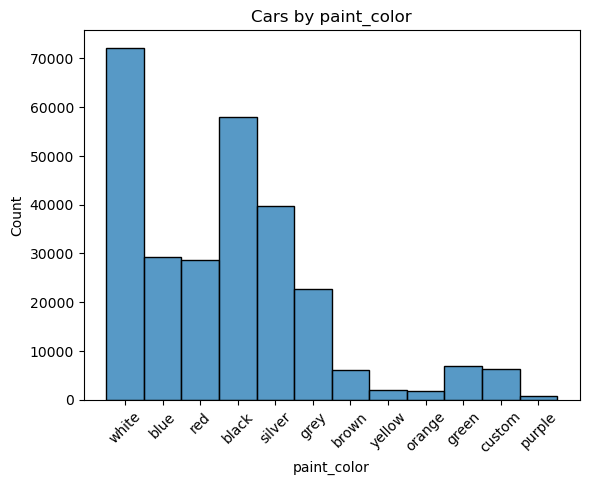

In [20]:
# Let's also look at how often these values appear by using a histogram for each
columns = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type' ,'paint_color']

for col in columns:
    sns.histplot(cars[col])
    plt.xticks(rotation=45)
    plt.title("Cars by " + col)
    plt.x_label = col
    plt.show()

The histograms show that for certain features, like fuel, title_status and transmission, most of the rows have the same value.
So these fields likely won't help our model differentiate much.

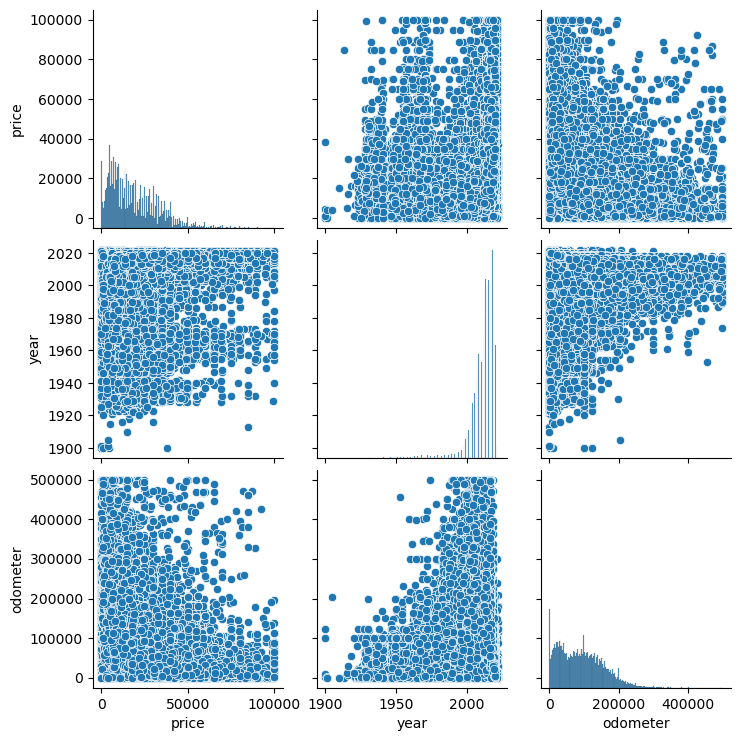

In [22]:
# now let's create scatterplots of the various numerical data columns
sns.pairplot(cars)

In [23]:
# let's take a closer look at the correlations of the numeric features
corr = cars.corr(numeric_only = True).round(2)
corr

,price,year,odometer
price,1.00,0.35,-0.49
year,0.35,1.00,-0.31
odometer,-0.49,-0.31,1.00


Based on the correlation data there seems to be a somewhat positive correlation between year and price.
(In other words, higher years (newer cars) have a higher price.
There is a somewhat negative correlation between odometer and price. In other words, cars with higher
odometer values (more miles) have a lower price.
Both of these relationships make sense and can be seen in the heatmap below.

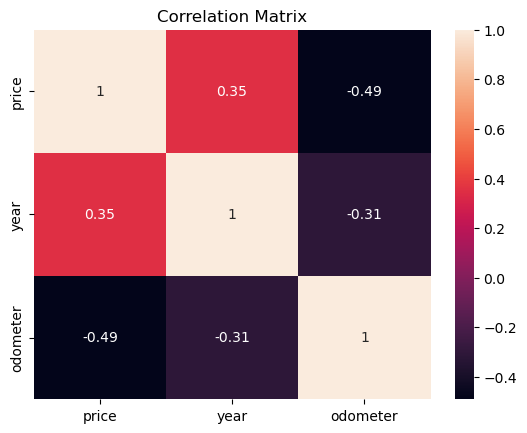

In [25]:
sns.heatmap(corr, annot = True);
plt.title('Correlation Matrix')
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [27]:
print("Percent of Null Values by Column")
print(cars.isnull().mean()*100)

Percent of Null Values by Column
region           0.000000
price            0.000000
year             0.284226
manufacturer     3.956596
model            1.147680
condition       38.393659
cylinders       40.623092
fuel             0.594875
odometer         0.000000
title_status     1.914424
transmission     0.387861
drive           30.472257
size            71.783085
type            21.705359
paint_color     29.577508
state            0.000000
dtype: float64


In [28]:
# look at basic statistics on the object columns
cars.describe(include = 'object')

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
count,389830,374406,385356,240160,231469,387511,382367,388318,271040,109998,305216,274528,389830
unique,404,42,27754,6,8,5,6,3,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,ca
freq,3384,64289,7017,118561,88118,327326,369131,303811,119632,57945,79644,72220,44313


In [29]:
# I'm going to leave out the fields fuel, title_status, and transmission because the majority of the rows all have the same 
# value in these fields. 

#And I will exclude size because over 70% of the rows are missing values in this field.

#I'm also going to leave out region manufacturer, model, and state.  They all have too many values.
#In addition, in order to make the models manageable, especially given the addition of degree 2 features, I am 
#also not including paint color in the models.

#let's just use the fields: odometer, year, cylinders, condition, drive, type, and price
cars_df = cars[['odometer', 'year', 'cylinders', 'condition', 'drive', 'type', 'price']]
cars_df.head()

,odometer,year,cylinders,condition,drive,type,price
27,57923.0,2014.0,8 cylinders,good,NaN,pickup,33590
28,71229.0,2010.0,8 cylinders,good,NaN,pickup,22590
29,19160.0,2020.0,8 cylinders,good,NaN,pickup,39590
30,41124.0,2017.0,8 cylinders,good,NaN,pickup,30990
31,128000.0,2013.0,6 cylinders,excellent,rwd,truck,15000


In [30]:
cars_df.shape

(389830, 7)

In [31]:
# lets also drop any cars from before 1960
cars_df = cars_df[cars_df["year"]>= 1960]

In [32]:
# now let's drop any rows that still have missing values
cars_df = cars_df.dropna()
cars_df.shape

(129548, 7)

In [33]:
#replace the string cylinder column with a numeric number of cylinders column
cars_df = cars_df[cars_df["cylinders"] != "other"]

cylinder_map = {
    '6 cylinders' : 6, 
    '4 cylinders' : 4,
    '8 cylinders' : 8, 
    '5 cylinders' : 5, 
    '10 cylinders' : 10, 
    '3 cylinders' : 3,
    '12 cylinders' : 12
}

cars_df['cylinder_num'] = cars_df['cylinders'].map(cylinder_map)
cars_df = cars_df.drop(['cylinders'], axis =1)

In [34]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129169 entries, 31 to 426878
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   odometer      129169 non-null  float64
 1   year          129169 non-null  float64
 2   condition     129169 non-null  object 
 3   drive         129169 non-null  object 
 4   type          129169 non-null  object 
 5   price         129169 non-null  int64  
 6   cylinder_num  129169 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 7.9+ MB


In [35]:
# now let's use one-hot encoding for the remaining categorical variables
cars_df = pd.get_dummies(cars_df, columns=['condition', 'drive', 'type'], drop_first=True, dtype='int64')
cars_df.head()

,odometer,year,price,cylinder_num,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,drive_fwd,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
31,128000.0,2013.0,15000,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32,68696.0,2012.0,27990,8,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
33,29499.0,2016.0,34590,6,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
34,43000.0,2019.0,35000,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
35,17302.0,2016.0,29990,6,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [36]:
X = cars_df.drop(['price'], axis=1)
y = cars_df[['price']]

# lets split the data into train and test datasets.  We can keep 30% for the test
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90418, 22) (38751, 22) (90418, 1) (38751, 1)


In [38]:
#Add Polynomial Features
poly = PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_train)
X_train_transform = pd.DataFrame(poly.transform(X_train), columns=poly.get_feature_names_out())
X_test_transform = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out())

In [39]:
# now we can scale the data
scale = StandardScaler()
X_train_sc = scale.fit_transform(X_train_transform)
X_test_sc = scale.fit_transform(X_test_transform)
X_train_df = pd.DataFrame(X_train_sc, columns=X_train_transform.columns)
X_test_df = pd.DataFrame(X_test_sc, columns=X_test_transform.columns)

In [40]:
# confirmed that the fields have been scaled to mean = 0, std = 1.
X_train_df.agg(["mean", "std"]).round(1)

,odometer,year,cylinder_num,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,drive_fwd,drive_rwd,...,type_sedan^2,type_sedan type_truck,type_sedan type_van,type_sedan type_wagon,type_truck^2,type_truck type_van,type_truck type_wagon,type_van^2,type_van type_wagon,type_wagon^2
mean,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [41]:
X_train_df.head()

,odometer,year,cylinder_num,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,drive_fwd,drive_rwd,...,type_sedan^2,type_sedan type_truck,type_sedan type_van,type_sedan type_wagon,type_truck^2,type_truck type_van,type_truck type_wagon,type_van^2,type_van type_wagon,type_wagon^2
0,0.895547,-0.302896,1.243301,-0.185442,1.219910,-0.341875,-0.065307,-0.049723,-0.70601,-0.552998,...,-0.592874,0.0,0.0,0.0,2.520961,0.0,0.0,-0.17063,0.0,-0.161955
1,-0.254662,0.616286,1.243301,-0.185442,-0.819733,-0.341875,-0.065307,-0.049723,-0.70601,-0.552998,...,-0.592874,0.0,0.0,0.0,-0.396674,0.0,0.0,-0.17063,0.0,-0.161955
2,-0.013618,0.501388,-0.002480,-0.185442,-0.819733,-0.341875,-0.065307,-0.049723,1.41641,-0.552998,...,-0.592874,0.0,0.0,0.0,-0.396674,0.0,0.0,-0.17063,0.0,-0.161955
3,0.698845,-0.532692,-0.002480,-0.185442,1.219910,-0.341875,-0.065307,-0.049723,1.41641,-0.552998,...,1.686700,0.0,0.0,0.0,-0.396674,0.0,0.0,-0.17063,0.0,-0.161955
4,-1.371912,0.731184,-0.002480,-0.185442,1.219910,-0.341875,-0.065307,-0.049723,-0.70601,-0.552998,...,-0.592874,0.0,0.0,0.0,-0.396674,0.0,0.0,-0.17063,0.0,-0.161955


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [43]:
# The first model is a linear regression model
lr = LinearRegression()
lr.fit(X_train_df, y_train)

LinearRegression()

In [44]:
# now lets create predictions using both the test and train data
lr_train_pred = lr.predict(X_train_df)
lr_test_pred = lr.predict(X_test_df)

In [45]:
# now we can see how the model did
lr_train_MSE = mean_squared_error(lr_train_pred, y_train['price'])
lr_test_MSE = mean_squared_error(lr_test_pred, y_test['price'])
lr_train_RMSE = root_mean_squared_error(lr_train_pred, y_train['price'])
lr_test_RMSE = root_mean_squared_error(lr_test_pred, y_test['price'])
lr_train_R2 = r2_score(lr_train_pred, y_train['price'])
lr_test_R2 = r2_score(lr_test_pred, y_test['price'])
print("linear regression results")
print("MSE for training data: ", lr_train_MSE.round(2))
print("MSE for test data: ", lr_test_MSE.round(2))
print("RMSE for training data: ", lr_train_RMSE.round(2))
print("RMSE for test data: ", lr_test_RMSE.round(2))
print("R2 Score for training data: ", lr_train_R2.round(4))
print("R2 Score for test data: ", lr_test_R2.round(4))

linear regression results
MSE for training data:  55132160.9
MSE for test data:  56214502.3
RMSE for training data:  7425.1
RMSE for test data:  7497.63
R2 Score for training data:  0.5362
R2 Score for test data:  0.5317


In [46]:
coefficients = lr.coef_
column_names = X_train_df.columns
for i in range(coefficients.size):
    print(column_names[i], "  ", coefficients[0][i])

odometer    252411.58374402285
year    -850047.9864863037
cylinder_num    -166884.7427572896
condition_fair    3410237510416328.5
condition_good    4999603606827712.0
condition_like new    -703207414179933.5
condition_new    -2117426641785758.5
condition_salvage    8142552467172477.0
drive_fwd    170367635540341.88
drive_rwd    25296518427831.176
type_bus    -216983552842005.4
type_convertible    3610780543413191.5
type_coupe    309006256630822.06
type_hatchback    -3938392793060919.0
type_mini-van    1406284145520509.5
type_offroad    4363852180272590.5
type_other    2291713425005316.5
type_pickup    548987674872836.94
type_sedan    381915769959768.94
type_truck    -5668184169139396.0
type_van    2753647850022826.0
type_wagon    -988313604605824.9
odometer^2    2764.1876722677553
odometer year    -253779.08843562056
odometer cylinder_num    -4993.59727762416
odometer condition_fair    297.1787805895983
odometer condition_good    -785.357727131408
odometer condition_like new    -875.95

In [47]:
# The second model is a Ridge Regression Model
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train_df, y_train)

Ridge(alpha=0.5)

In [48]:
ridge_train_pred = ridge.predict(X_train_df)
ridge_test_pred = ridge.predict(X_test_df)

In [49]:
# now we can see how the model did
ridge_train_MSE = mean_squared_error(ridge_train_pred, y_train['price'])
ridge_test_MSE = mean_squared_error(ridge_test_pred, y_test['price'])
ridge_train_RMSE = root_mean_squared_error(ridge_train_pred, y_train['price'])
ridge_test_RMSE = root_mean_squared_error(ridge_test_pred, y_test['price'])
ridge_train_R2 = r2_score(ridge_train_pred, y_train['price'])
ridge_test_R2 = r2_score(ridge_test_pred, y_test['price'])
print("ridge regression results")
print("run using alpha = 0.5")
print("MSE for training data: ", ridge_train_MSE.round(2))
print("MSE for test data: ", ridge_test_MSE.round(2))
print("RMSE for training data: ", ridge_train_RMSE.round(2))
print("RMSE for test data: ", ridge_test_RMSE.round(2))
print("R2 Score for training data: ", ridge_train_R2.round(4))
print("R2 Score for test data: ", ridge_test_R2.round(4))

ridge regression results
run using alpha = 0.5
MSE for training data:  57381175.24
MSE for test data:  58398809.85
RMSE for training data:  7575.04
RMSE for test data:  7641.91
R2 Score for training data:  0.4908
R2 Score for test data:  0.483


In [50]:
coefficients = ridge.coef_
column_names = X_train_df.columns
for i in range(coefficients.size):
    print(column_names[i], "  ", coefficients[0][i])

odometer    102030.05660561826
year    -362606.10589044343
cylinder_num    -58486.19370495269
condition_fair    7269.191240956571
condition_good    -52763.195717860915
condition_like new    -644.7440404148113
condition_new    1901.698335053366
condition_salvage    1464.5540792909999
drive_fwd    15308.809855744921
drive_rwd    32262.61369357075
type_bus    -2683.0784618747934
type_convertible    24683.610387535064
type_coupe    40014.561936193815
type_hatchback    14948.16589797314
type_mini-van    967.724953675168
type_offroad    3453.0434388783137
type_other    382.099640100647
type_pickup    -11927.612047983912
type_sedan    19444.723704891374
type_truck    -43251.06421886461
type_van    5175.221911651477
type_wagon    17870.12131428971
odometer^2    4294.009732179035
odometer year    -105681.75579903892
odometer cylinder_num    -5416.1073322914
odometer condition_fair    581.2435676839938
odometer condition_good    -1157.1414956298484
odometer condition_like new    -840.02994663410

In [51]:
# The third model is a Lasso Model
# This model has convergence errors when using the polynomial features so I am going to 
# just use the scaled degree 1 data
X_train_sc2 = scale.fit_transform(X_train)
X_test_sc2 = scale.fit_transform(X_test)
X_train_df2 = pd.DataFrame(X_train_sc2, columns=X_train.columns)
X_test_df2 = pd.DataFrame(X_test_sc2, columns=X_test.columns)

lasso = Lasso(alpha = 0.5)

lasso.fit(X_train_df2, y_train)

Lasso(alpha=0.5)

In [52]:
lasso_train_pred = lasso.predict(X_train_df2)
lasso_test_pred = lasso.predict(X_test_df2)

In [53]:
# now we can see how the model did
lasso_train_MSE = mean_squared_error(lasso_train_pred, y_train['price'])
lasso_test_MSE = mean_squared_error(lasso_test_pred, y_test['price'])
lasso_train_RMSE = root_mean_squared_error(lasso_train_pred, y_train['price'])
lasso_test_RMSE = root_mean_squared_error(lasso_test_pred, y_test['price'])
lasso_train_R2 = r2_score(lasso_train_pred, y_train['price'])
lasso_test_R2 = r2_score(lasso_test_pred, y_test['price'])
print("lasso regression results")
print("run using alpha = 0.5")
print("MSE for training data: ", lasso_train_MSE.round(2))
print("MSE for test data: ", lasso_test_MSE.round(2))
print("RMSE for training data: ", lasso_train_RMSE.round(2))
print("RMSE for test data: ", lasso_test_RMSE.round(2))
print("R2 Score for training data: ", lasso_train_R2.round(4))
print("R2 Score for test data: ", lasso_test_R2.round(4))

lasso regression results
run using alpha = 0.5
MSE for training data:  75872116.15
MSE for test data:  76561641.62
RMSE for training data:  8710.46
RMSE for test data:  8749.95
R2 Score for training data:  0.2263
R2 Score for test data:  0.2159


In [54]:
coefficients = lasso.coef_
column_names = X_train_df2.columns
for i in range(coefficients.size):
    print(column_names[i], "  ", coefficients[i])

odometer    -5344.652554023152
year    3993.9573945867205
cylinder_num    2604.489311152202
condition_fair    -494.5300963620796
condition_good    422.28209274606564
condition_like new    413.83435028297464
condition_new    332.5005416013275
condition_salvage    -226.1572322873863
drive_fwd    -1806.2880543478814
drive_rwd    -273.5921504362528
type_bus    94.98112799724856
type_convertible    655.5748410450159
type_coupe    1055.900574052598
type_hatchback    -209.89433371085417
type_mini-van    -75.13365524813413
type_offroad    385.0909452836194
type_other    1112.4742577896677
type_pickup    1740.2538070552544
type_sedan    -705.7036147745202
type_truck    2320.144357866322
type_van    310.2608120429965
type_wagon    -292.4759782184959


In [55]:
# now let's graph the results of the training data
y_train_results = y_train.copy()
y_train_results["linear"] = lr_train_pred
y_train_results["ridge"] = ridge_train_pred
y_train_results["lasso"] = lasso_train_pred

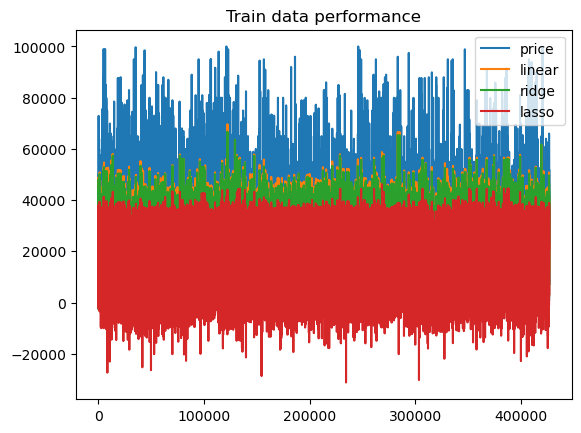

In [56]:
#originally used a plotly graph that was more interactive but it resulted in an enormous file size.
y_train_results.sort_index().plot(kind = 'line', title = "Train data performance")
plt.legend(loc='upper right')
plt.show()

In [57]:
# now let's graph the results of the test data
y_test_results = y_test.copy()
y_test_results["linear"] = lr_test_pred
y_test_results["ridge"] = ridge_test_pred
y_test_results["lasso"] = lasso_test_pred

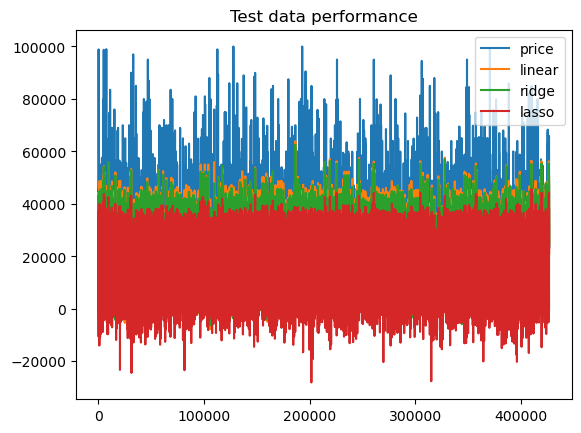

In [58]:
#originally used a plotly graph that was more interactive but it resulted in an enormous file size.
y_test_results.sort_index().plot(kind = 'line', title = "Test data performance")
plt.legend(loc='upper right')
plt.show()

In [59]:
#Let's explore Ridge Regression a bit more and look at different alpha and polynomial options
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scale', StandardScaler()),
    ('model', Ridge())
])
pipe

param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],
    'poly__degree': [1, 2]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs = -1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(best_model)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scale', StandardScaler()),
                ('model', Ridge(alpha=0.01))])


In [60]:
print(grid_search.best_params_)

{'model__alpha': 0.01, 'poly__degree': 2}


In [61]:
# let's rerun the model in the pipeline with the best parameters:
# Change the parameters of the steps in the pipeline
updated_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree = 2)),
    ('scale', StandardScaler()),
    ('model', Ridge(alpha = 0.01))
])

# Refit the pipeline with the updated parameters
updated_pipe.fit(X_train, y_train)

#Now let's create predictions on the training and test data and see how we did 
new_ridge_train_pred = updated_pipe.predict(X_train)
new_ridge_test_pred = updated_pipe.predict(X_test)

#And let's analyze the results
new_ridge_train_MSE = mean_squared_error(new_ridge_train_pred, y_train['price'])
new_ridge_test_MSE = mean_squared_error(new_ridge_test_pred, y_test['price'])
new_ridge_train_RMSE = root_mean_squared_error(new_ridge_train_pred, y_train['price'])
new_ridge_test_RMSE = root_mean_squared_error(new_ridge_test_pred, y_test['price'])
new_ridge_train_R2 = r2_score(new_ridge_train_pred, y_train['price'])
new_ridge_test_R2 = r2_score(new_ridge_test_pred, y_test['price'])
print("updated ridge regression results")
print("polynomial degree: 2, alpha: 0.01")
print("MSE for training data: ", new_ridge_train_MSE.round(2))
print("MSE for test data: ", new_ridge_test_MSE.round(2))
print("RMSE for training data: ", new_ridge_train_RMSE.round(2))
print("RMSE for test data: ", new_ridge_test_RMSE.round(2))
print("R2 Score for training data: ", new_ridge_train_R2.round(4))
print("R2 Score for test data: ", new_ridge_test_R2.round(4))

updated ridge regression results
polynomial degree: 2, alpha: 0.01
MSE for training data:  55127275.49
MSE for test data:  56166697.99
RMSE for training data:  7424.77
RMSE for test data:  7494.44
R2 Score for training data:  0.5346
R2 Score for test data:  0.5273


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Summary of results:
Overall none of the models did a great job predicting the price.

Adding Polynomials features seemed to help a bit as the Linear Regression and Ridge Regression
models did a bit better when I added the degree = 2 features.  When I initially created them with 
just the degree 1 features, their R2 scores were much lower.

However, the Lasso model was not able to converge with this many features so I was forced to run it 
with just the scaled degree 1 features.

Looking at the predictions, vs actual prices, none of the models seemed to come particularly close to correctly predicting price.
However, the Linear Regression and Ridge Regression models did better, suggesting that being able to 
add the degree 2 features was helpful.

In all of the instances, the test data results had higher MSEs than their corresponding training data results, and slightly 
R2 scores, but in all instances the test data was not much worse.  This is a good sign overall and perhaps due to the large
number of rows in the dataset, even after dropping a number of rows during the cleaning process.

However, the original datasets had a number of issues that had to be addressed before running the models.
Many rows and columns were missing values and the dataset contained very few numeric features, 
which was a significant limitation given that all of these models are really dependent on numeric features.

Although I used one-hot encoding to convert some categorical features to numeric ones, this did not create
a significant improvement to the models.

I did remove outliers in the price and odometer category, as well as cars from before 1960, as these seemed be impacting
the accuracy of the model predictions.

Overall of the models that I used, the Linear Regression Model had the highest R2 score.  After tuning the Ridge Regression
model using GridSearchCV, it's alpha was lowered and it performed better.  However, with the alpha of 0.01, this model behaved
more similarly to the Linear Regression model than it did when it had a higher alpha hyperparameter.

Perhaps data with additional features, particularly more numeric ones, could improve these models.
Or perhaps other models types might be better predictors of used car price.

Examining the coefficients in the Lasso model (which is a bit simpler given that they are just degree 1 columns)
suggests that some of the factors that contribute to a higher used car price are:
• lower odometer readings,
• more recent year,
• better condition,
• higher number of cylinders
In addition, certain car types, such as coupes, convertibles, pickups and trucks also tend to predict a higher price than other car types


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Based on the findings described above, additional work is needed before high quality results can be provided to the client

This might include a combination of data with additional features and improved models.

However, there are some initial indications of which types of cars might have higher used car sale prices.
This initial analysis suggests that some of the factors that contribute to a higher used car price are: 
• lower odometer readings, 
• more recent year (newer car), 
• better condition, 
• higher number of cylinders 
In addition, certain car types, such as coupes, convertibles, pickups and trucks also tend to have a higher price than other car types